## Page Classification

A very important task for PDF and document processing. For this benchmark, we will run Docprompt Classification Task over the [Document Classification Dataset](https://www.kaggle.com/datasets/ritvik1909/document-classification-dataset/data) from Kaggle.

This is a small subset of the rvl cdip dataset, containing 3 out of the 16 classes:
- `email`
- `resume`
- `scientific_publication`

In [1]:
import zipfile
import os
import base64
from PIL import Image
import io
import shutil

# Assuming the zip file is in the same directory as the notebook
zip_file_path = '../data/benchmark/document_classifications.zip'
output_directory = 'extracted_documents'

# Dictionary to store our results
document_data = {
    'email': [],
    'resume': [],
    'scientific_publication': []
}

# Function to encode image to base64
def encode_image(image_path):
    with Image.open(image_path).convert('RGB') as img:
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='PNG', optimize=True)
        return base64.b64encode(img_byte_arr.getvalue()).decode('utf-8')

try:
    # Unzip the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_directory)

    # Process each directory
    for category in document_data.keys():
        category_path = os.path.join(output_directory, category)
        for filename in os.listdir(category_path):
            if filename.endswith('.png'):
                file_path = os.path.join(category_path, filename)
                encoded_image = encode_image(file_path)
                document_data[category].append(encoded_image)

    # Print the number of images in each category
    for category, images in document_data.items():
        print(f"{category}: {len(images)} images")

finally:
    # Clean up: remove the output directory and its contents
    if os.path.exists(output_directory):
        shutil.rmtree(output_directory)
        print(f"Cleaned up {output_directory}")

email: 55 images
resume: 55 images
scientific_publication: 55 images
Cleaned up extracted_documents


Let's take a peek at a sample image from each category

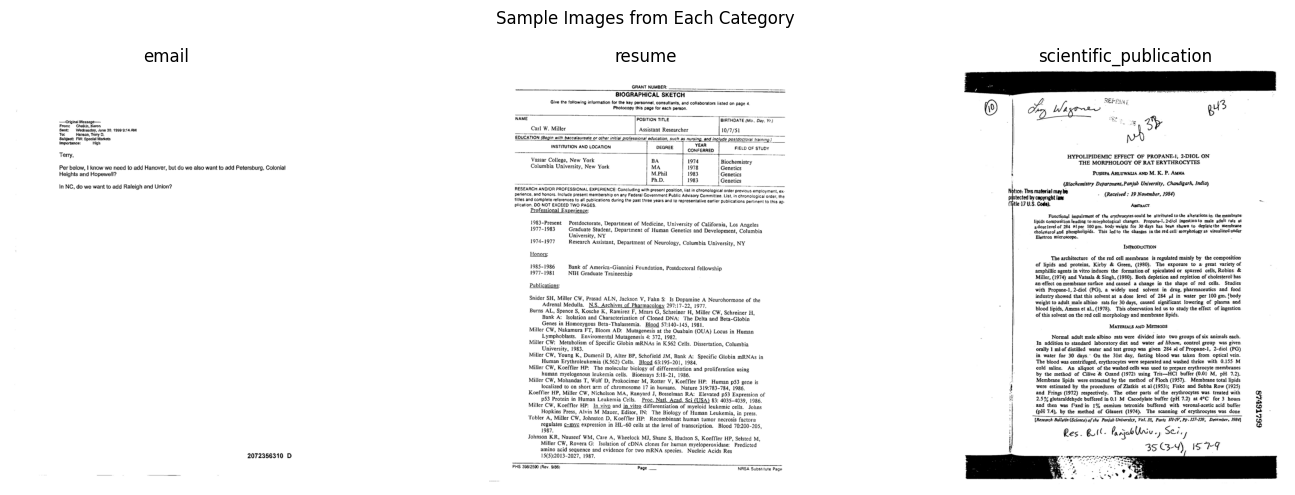

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def decode_image(base64_string):
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))
    return np.array(img)  # Convert to numpy array

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Sample Images from Each Category')

for i, category in enumerate(document_data.keys()):
    if document_data[category]:
        img_array = decode_image(document_data[category][0])
        axs[i].imshow(img_array)
        axs[i].set_title(category)
        axs[i].axis('off')
    else:
        axs[i].text(0.5, 0.5, f"No images in {category}", ha='center', va='center')

plt.tight_layout()
plt.show()

In [3]:
document_data['email'][0][:100] + "..."

'iVBORw0KGgoAAAANSUhEUgAAAvIAAAPoCAIAAAAzw41SAACghUlEQVR42uzddVhUacM/8HuK7u5GFERUUBDBAgMDEFvsblfXWmvt...'

Let's transform all of the data into unique Image URIs, that we can use for running our benchmark with Anthropic.

In [4]:
for key, image in document_data.items():
    for img_i in range(len(images)):
        # Create a base64 uri for the image
        document_data[key][img_i] = f"data:image/png;base64,{document_data[key][img_i]}"
    

In [5]:
document_data['email'][0][:100] + "..."

'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAvIAAAPoCAIAAAAzw41SAACghUlEQVR42uzddVhUacM/8HuK7u5GFE...'

With our data prepared, we can move on to utilizing DocPrompt functionality to setup and execute our benchmark.

In [6]:
import pandas as pd



# Create a DataFrame to store our dataset in a tabular format

rows = []
prev_images = set()
for key, images in document_data.items():
    print(key)
    image_set = set(images)

    # Check for duplicate images
    if prev_images.intersection(image_set):
        print(f"Duplicate images found in {key}")
    
    prev_images = image_set
    rows.extend([{'data': img, 'label': key} for img in images])
    
df = pd.DataFrame(rows)


df.describe()


email
resume
scientific_publication


,data,label
count,165,165
unique,165,3
top,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",email
freq,1,55


In [22]:
import importlib

from docprompt.tasks.classification.base import ClassificationInput
from docprompt.tasks.classification import anthropic
from docprompt.utils import inference
from dotenv import load_dotenv


importlib.reload(anthropic)
importlib.reload(inference)

load_dotenv("../.env")

# Setup our task
t_input = ClassificationInput(
    type='single_label',
    labels=['label_email', 'label_resume', 'label_scientific_publication'],
    descriptions=[
        "An email or correspondance.",
        'A resume or CV.',
        "A page, abstract, or other excerpt from a scientific publication."

    ]
)


image_uris = [img for img in df['data']]


results = await anthropic.classify_images(image_uris, t_input)


Processing messages:   0%|          | 0/165 [00:00<?, ?it/s]/Users/jackmoffatt/Development/repositories/Docprompt/.venv/lib/python3.11/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[str, list[OpenAIComplexContent]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
Processing messages:  99%|█████████▉| 164/165 [04:59<00:01,  1.83s/it]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/Users/jackmoffatt/Development/repositories/Docprompt/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3506, in run_code
    await eval(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/18/gysclhzd7dqcgbf94d0nx0mh0000gn/T/ipykernel_56656/3757613215.py", line 30, in <module>
    results = await anthropic.classify_images(image_uris, t_input)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jackmoffatt/Development/repositories/Docprompt/docprompt/tasks/classification/anthropic.py", line 159, in classify_images
  File "/Users/jackmoffatt/Development/repositories/Docprompt/docprompt/utils/inference.py", line 67, in run_batch_inference_anthropic
  File "/Users/jackmoffatt/.pyenv/versions/3.11.6/lib/python3.11/asyncio/tasks.py", line 611, in _wait_for_one
    f = await done.get()
        ^^^^^^^^^^^^^^^^
  File "/Users/jackmoffatt/.pyenv/versions/3.11.6/lib/python3.11/asyncio

In [12]:
# Now let's merge the results back into our DataFrame

predicted_labels = [res.labels.replace("label_", "") for res in results]

df['predicted_label'] = predicted_labels

df['accuracy'] = df.apply(lambda row: int(row['label'] == row['predicted_label']), axis=1)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Confusion Matrix (manual calculation)
labels = df['label'].unique()
cm = np.zeros((len(labels), len(labels)), dtype=int)
for true, pred in zip(df['label'], df['predicted_label']):
    i, j = list(labels).index(true), list(labels).index(pred)
    cm[i, j] += 1

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, 
            yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 2. Accuracy by Label
accuracy_by_label = df.groupby('label')['accuracy'].mean()
plt.figure(figsize=(10, 6))
accuracy_by_label.plot(kind='bar')
plt.title('Accuracy by Label')
plt.xlabel('Label')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracy_by_label):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
plt.show()

# 3. Overall Accuracy Pie Chart
overall_accuracy = df['accuracy'].mean()
plt.figure(figsize=(8, 8))
plt.pie([overall_accuracy, 1 - overall_accuracy], 
        labels=['Correct', 'Incorrect'], 
        autopct='%1.1f%%', 
        colors=['#66b3ff', '#ff9999'])
plt.title('Overall Prediction Accuracy')
plt.show()

# Print overall accuracy
print(f"Overall Accuracy: {overall_accuracy:.2%}")